# Tranfer learning with TensorFlow Part 3 : Scaling up(Food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.9.1


In [ ]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.12.0


In [ ]:
pip install tensorflow==2.9.1

In [ ]:
print(tf.__version__)

2.9.1


In [ ]:
# Check to see if using GPU
!nvidia-smi

Thu Jul 13 05:44:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Downloading helper functions  

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-14 04:48:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-14 04:48:02 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, compare_historys, create_tensorboard_callback

## 101 Food Classes: working with less data

Our goal is to beat the original Food 101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food 101 dataset but has been preprocessed using the image_data_modification
notebook-  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir =  "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


--2023-07-14 04:48:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   239MB/s    in 6.1s    

2023-07-14 04:48:33 (254 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
# How many image_classes/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_

In [ ]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are steps we're going to take:
 * Create a ModelCheckpoint callback
 * Create a data augmentation layer to build data augmentation right into the model
 * Build a headless(no top layer) Functional EfficentNetB0 backboned-model(we'll create our own output layer)
 * Compile our model
 * Feature extract for 5 full passes(5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only =True,
                                                     monitor="val_accuracy"
                                                     ,save_best_only=True)

In [ ]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
# 1. Create a base model with Keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#  2. Freeze the layers
base_model.trainable = False

# 3. Create a input layer
inputs =layers.Input(shape = (224,224,3), name="input_layer")

# include data augmentaion layer
x = data_augmentation(inputs)#augment imags(only happens during training)

# 4. Pass the input layer to base model
x = base_model(x, training=False) #put the base model in inference mode so weights which need to stay frozen remains frozen

# 5. Average pooling the outputs of the base model(aggregate all the most important information, reduce the number of computation)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 6. Dense output layer
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Create a model
model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fitting the model
history_model_0 = model_0.fit(train_data_all_10_percent,
                              validation_data=(test_data),
                              validation_steps=(0.15 * len(test_data)),
                              epochs=5,
                              callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 100s 364ms/step - loss: 3.3667 - accuracy: 0.2758 - val_loss: 2.4980 - val_accuracy: 0.4653
Epoch 2/5
237/237 [==============================] - 72s 302ms/step - loss: 2.1970 - accuracy: 0.4958 - val_loss: 2.0737 - val_accuracy: 0.5066
Epoch 3/5
237/237 [==============================] - 67s 280ms/step - loss: 1.8238 - accuracy: 0.5603 - val_loss: 1.9145 - val_accuracy: 0.5260
Epoch 4/5
237/237 [==============================] - 62s 262ms/step - loss: 1.5930 - accuracy: 0.6157 - val_loss: 1.8453 - val_accuracy: 0.5268
Epoch 5/5
237/237 [==============================] - 61s 257ms/step - loss: 1.4535 - accuracy: 0.6417 - val_loss: 1.7802 - val_accuracy: 0.5365


In [ ]:
results_model_0 = model_0.evaluate(test_data)

790/790 [==============================] - 65s 83ms/step - loss: 1.5919 - accuracy: 0.5768


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

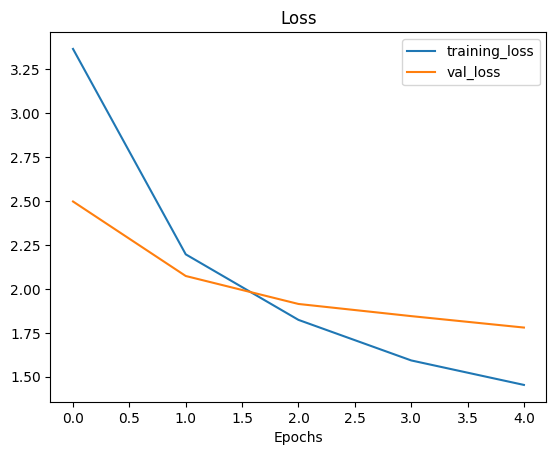

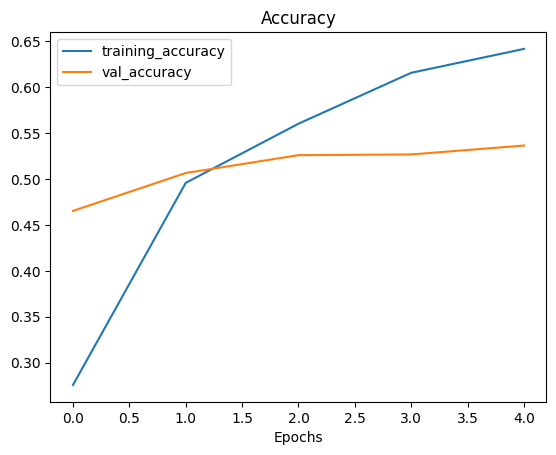

In [ ]:
plot_loss_curves(history_model_0)

## Fine tuning

In [ ]:
# Unfreeze all of the layer is the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile the model with lower learning rate
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Trainable layers in model
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for i , layer in enumerate(model_0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
initial_epoch = 5
fine_tune_epochs= initial_epoch + 5

history_model_0_fine_tune= model_0.fit(train_data_all_10_percent,
                                      validation_data=(test_data),
                                      validation_steps=(0.15 * len(test_data)),
                                      epochs=fine_tune_epochs,
                                      initial_epoch=history_model_0.epoch[-1]
                                      )

Epoch 5/10
237/237 [==============================] - 65s 237ms/step - loss: 1.2122 - accuracy: 0.6834 - val_loss: 1.7708 - val_accuracy: 0.5391
Epoch 6/10
237/237 [==============================] - 56s 237ms/step - loss: 1.0937 - accuracy: 0.7075 - val_loss: 1.7632 - val_accuracy: 0.5397
Epoch 7/10
237/237 [==============================] - 50s 211ms/step - loss: 1.0220 - accuracy: 0.7281 - val_loss: 1.7750 - val_accuracy: 0.5407
Epoch 8/10
237/237 [==============================] - 51s 214ms/step - loss: 0.9448 - accuracy: 0.7452 - val_loss: 1.7767 - val_accuracy: 0.5404
Epoch 9/10
237/237 [==============================] - 49s 205ms/step - loss: 0.8965 - accuracy: 0.7601 - val_loss: 1.7875 - val_accuracy: 0.5368
Epoch 10/10
237/237 [==============================] - 49s 206ms/step - loss: 0.8389 - accuracy: 0.7741 - val_loss: 1.8050 - val_accuracy: 0.5368


In [ ]:
results_model_model_0_fine_tune = model_0.evaluate(test_data)

790/790 [==============================] - 65s 82ms/step - loss: 1.4973 - accuracy: 0.6021


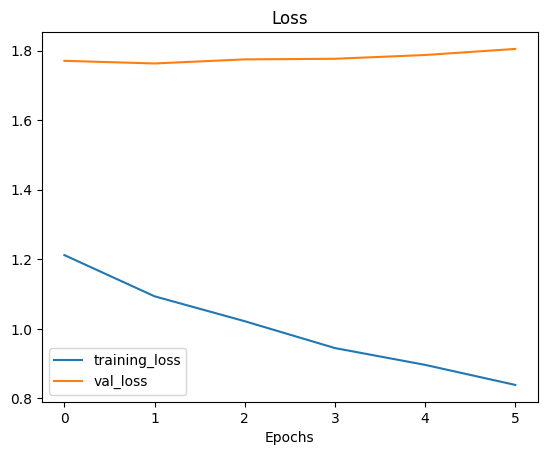

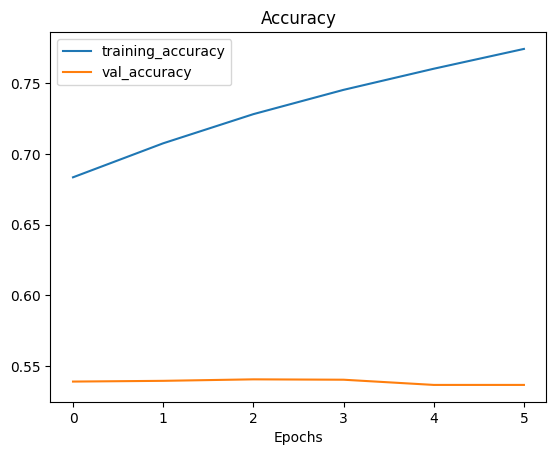

In [ ]:
plot_loss_curves(history_model_0_fine_tune)

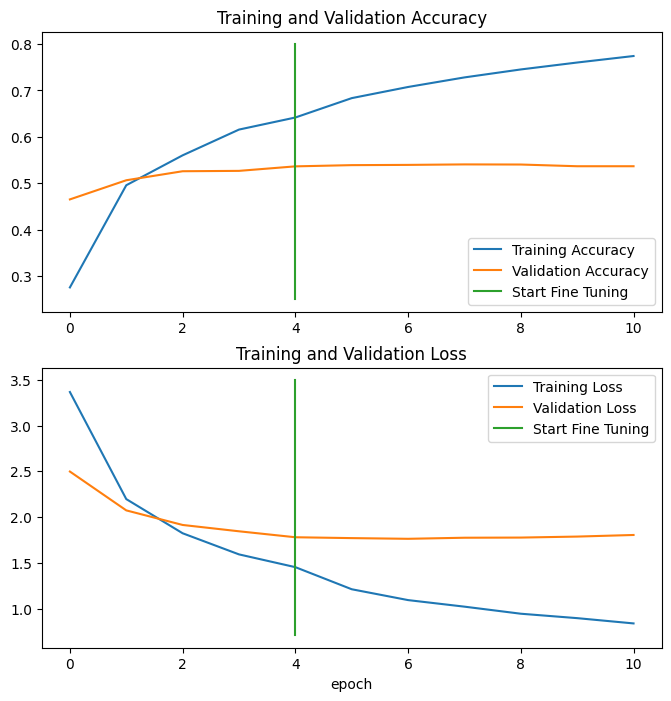

In [ ]:
# compares the history of feature extractor model with fine tuned model
compare_historys(original_history=history_model_0, new_history=history_model_0_fine_tune, initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
model_0.save("drive/MyDrive/models/101_food_classes_model_fine_tuned")

In [ ]:
loaded_model  = tf.keras.models.load_model("drive/MyDrive/models/101_food_classes_model_fine_tuned")

In [ ]:
#Evaluate loaded model and compare performsnce to pre-saved model
loaded_model.evaluate(test_data)

790/790 [==============================] - 68s 83ms/step - loss: 1.4973 - accuracy: 0.6021


[1.4973419904708862, 0.6020990014076233]

In [ ]:
# Results from presaved model
results_model_model_0_fine_tune

[1.4973419904708862, 0.6020990014076233]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong


In [ ]:
import tensorflow as tf

#Download pretrained model(0ne that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2023-07-14 04:49:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   165MB/s    in 0.3s    

2023-07-14 04:49:17 (165 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate the loaded model(the one we just downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 70s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 65s 81ms/step


In [ ]:
# Ḥow many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class(in this case we get 101 probailities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred_classes we have?
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them , we need to compare them to the original test dataset

In [ ]:
# To get the test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test label looks like [0,0,0,1,...0,0] we want the index value where'1' appears
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

## Evaluating our model's predictions
 One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                 y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

## Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data.class_names

In [ ]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vetically)###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20,
                     savefig=True)

Output hidden; open in https://colab.research.google.com to view.

## Let's keep the evaluation train going, time for a classification report

SciKit-learn has a helpful function for acquiring many different classification metrics per class(e.g. precision, recall, and F1) called classification_report, let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all our classes F1-scores...

In [ ]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in  classification_report_dict.items():
    if k == "accuracy": #stop once we get to acuracy key
       break
    else:
        #add class names and f1 scores to new dict
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1 scores into dataframe for visualztion
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


import numpy as np
from google.colab import autoviz
df_5125222597130804055 = autoviz.get_registered_df('df_5125222597130804055')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5125222597130804055, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1427271061853370919 = autoviz.get_registered_df('df_1427271061853370919')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1427271061853370919, *['f1-score'], **{})
chart

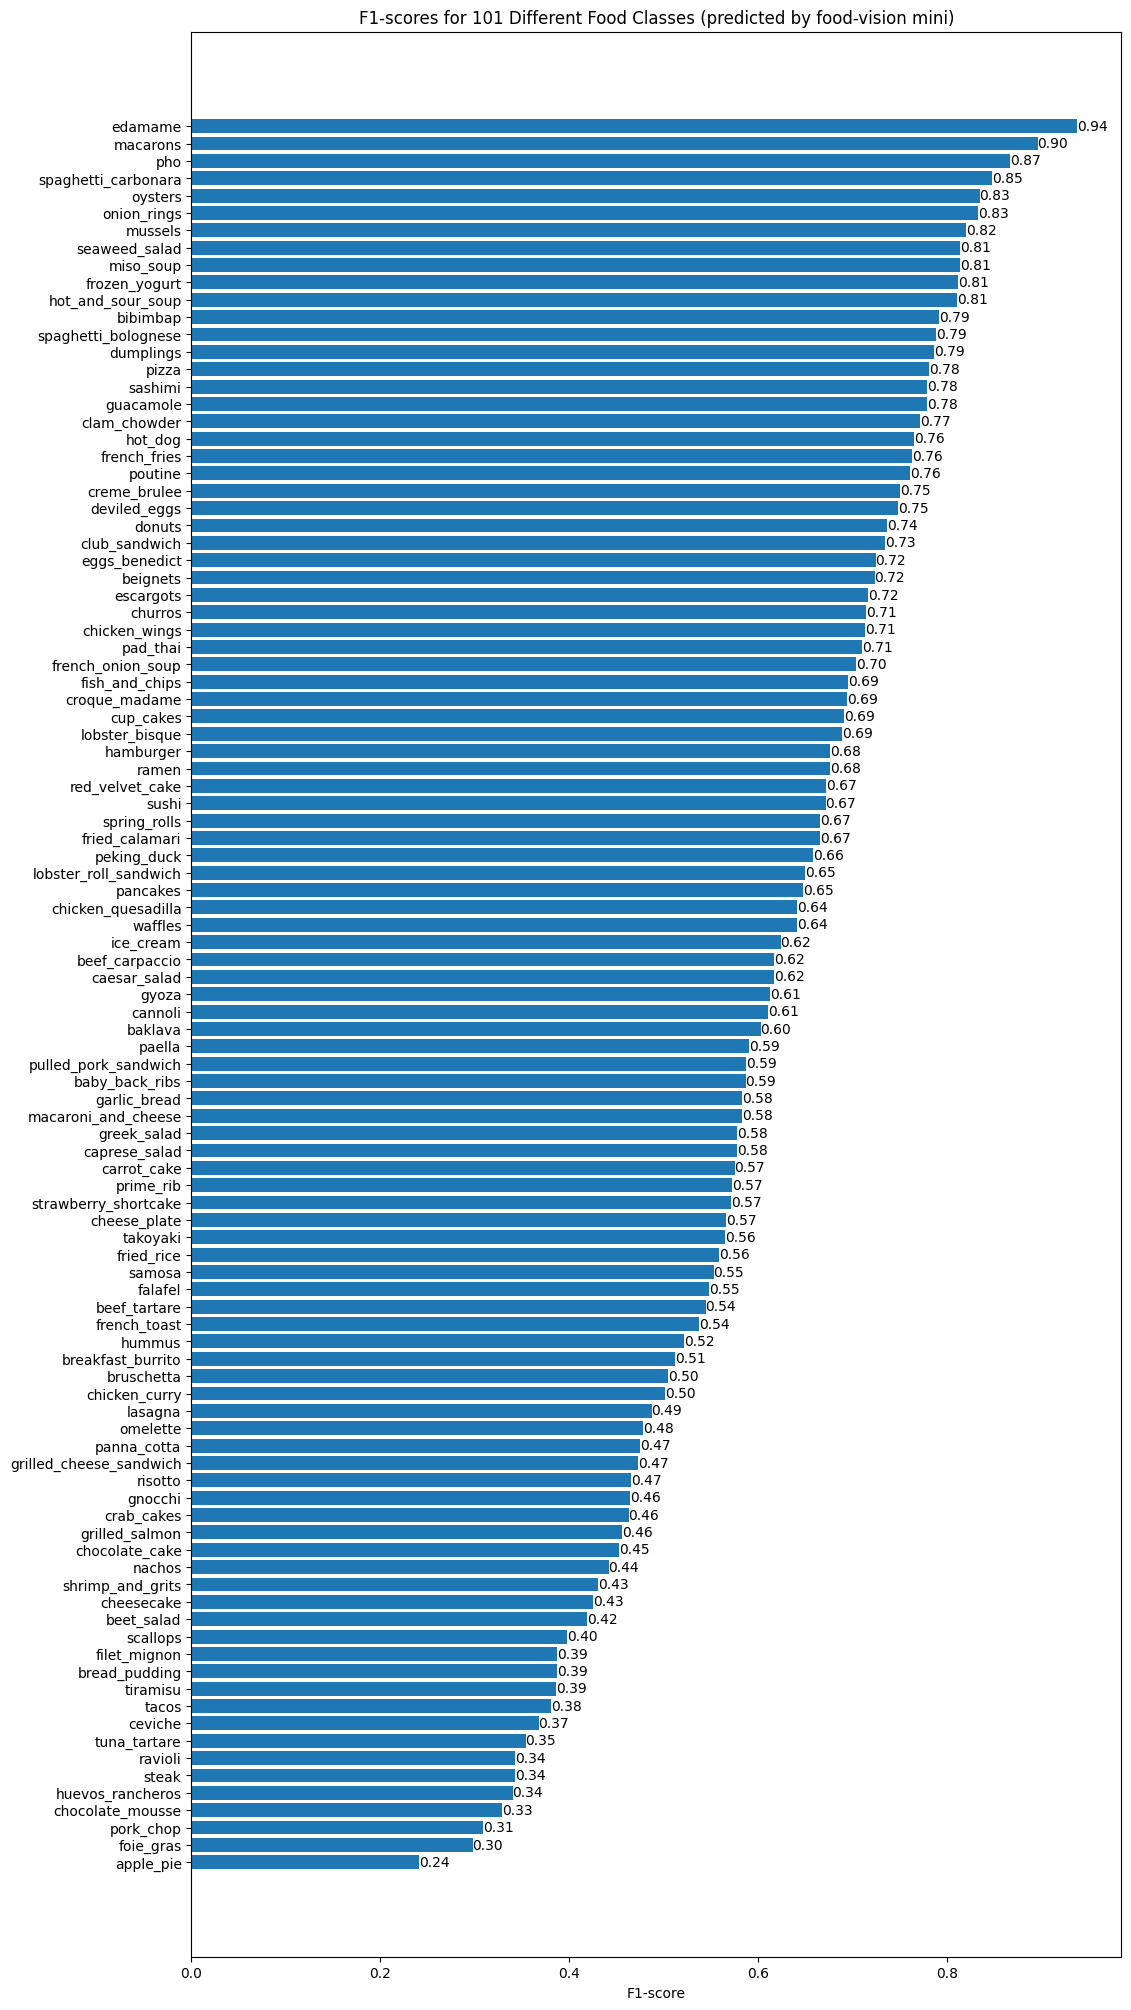

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))

# Plot the horizontal bars
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

# Set the y-ticks and labels
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])

# Set the x-label and title
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by food-vision mini)")

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, score in enumerate(f1_scores["f1-score"].values):
    ax.text(score, i, f"{score:.2f}", ha="left", va="center")

plt.show()

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own)

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target filepath using tf.io.read_file()
* Turn the image into Tensor using tf.io.decode_image()
* Resize the image to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)


In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale=True):
  """
   Reads in an image from filename, turns it to a tensor and reshapes into
   specified shape(img_shape, img_shape, color_channels=3)

   Args:
      filename (str): path to target image
      image_shape (int): height/width dimension of target image size
      scale (bool): scale pixel values from 0-255 to 0-1 or not

   Returns:
      Image tensor of shape (img_shape, img_shape, 3)
   """
  #  Read in the image
  img = tf.io.read_file(filename=filename)

  # Decode into tensor
  img= tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(images=img, size=[img_shape,img_shape])

  # Scale? yes/no
  if scale:
     # Rescale the image(get all values between 0 and 1)
     return img/255.
  else:
     return img #don't need to rescale images for EfficientNet models in TensorFlow


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label predictions.
Specifically, we'll write some code to:
  1. Load a few random images from the test dataset
  2. Make predictions on the loaded images
  3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 29ms/step


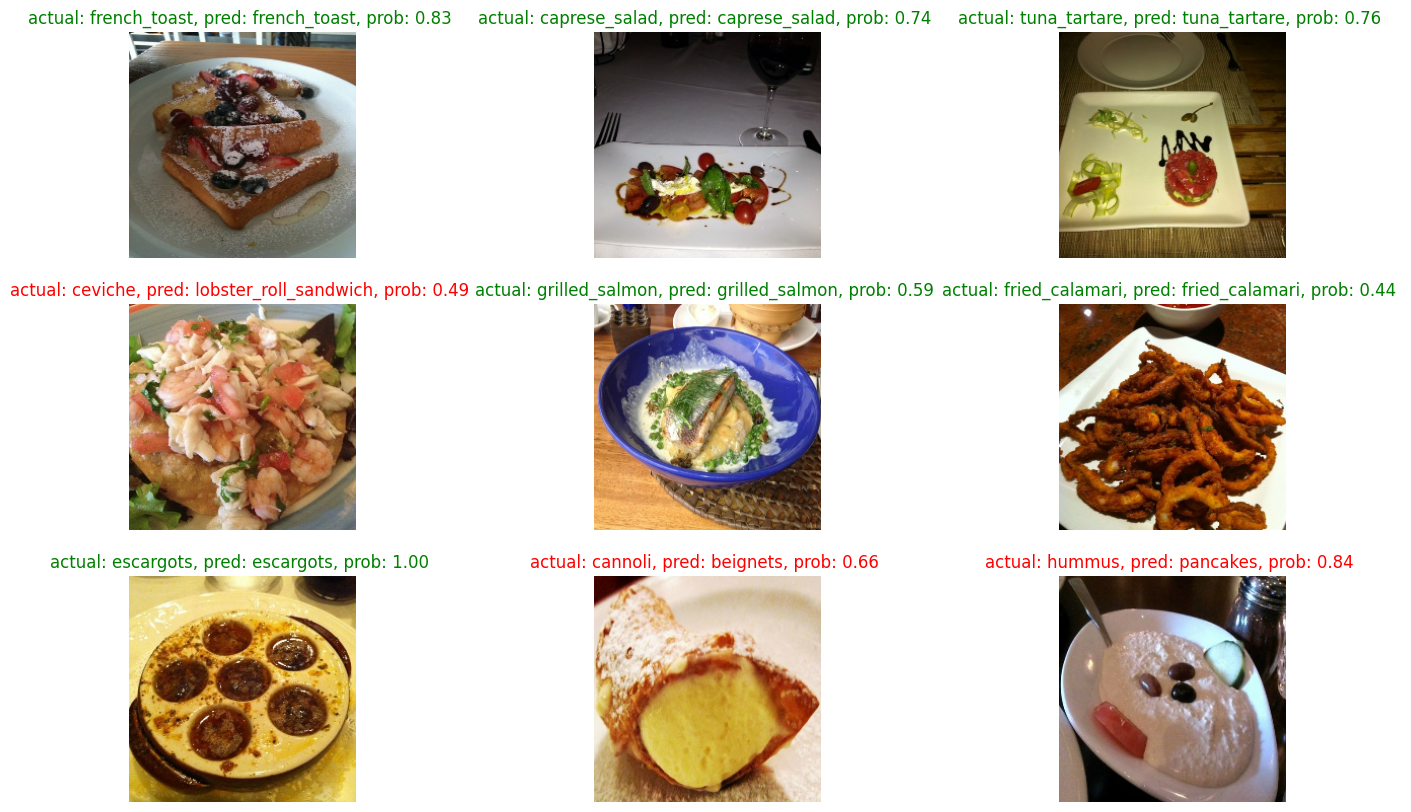

In [ ]:
# Make preds on series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(9):
  # choose a random image(s) from a random class(es)
  class_name =  random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))  # Get predictions probability array
  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index

  # Plot the image
  plt.subplot(3,3,i+1)
  plt.imshow(img/255.)
  if class_name ==  pred_class: # If predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f} ", c= title_color)
  plt.axis(False);

## Finding the most wrong prediction

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas DataFrame to find all